# PyTorch Tutorial
### Author: Mateo Perez

This notebook is a brief tutorial for [PyTorch](https://pytorch.org/) with deep reinforcement learning in mind. It consists of four parts:

[**1) Warmup: Taking Derivatives**](#1\)-Warmup:-Taking-Derivatives)

[**2) Ordinary Least Squares via Gradient Descent**](#2\)-Ordinary-Least-Squares-via-Gradient-Descent)

[**3) Training a Neural Network on MNIST**](#3\)-Training-a-Neural-Network-on-MNIST)

[**4) Deep Deterministic Policy Gradient (DDPG)**](#4\)-Deep-Deterministic-Policy-Gradient-\(DDPG\))

Let's begin by importing whats needed.

In [2]:
# PyTorch
import torch
import torch.nn as nn # Neural network specific functions

# torchvision, a PyTorch library for computer vision
from torchvision import datasets, transforms

# gymnasium, a library containing reinforcement learning environments
import gymnasium as gym

# TensorBoard, for training visualization
from torch.utils.tensorboard import SummaryWriter

# Miscellaneous additional packages
import matplotlib.pyplot as plt
import matplotlib
import scipy
import numpy as np
from tqdm import tqdm
from copy import deepcopy

## 1) Warmup: Taking Derivatives

PyTorch is a scientific computing library focused on applications for deep neural networks. It operates much like [Numpy](https://numpy.org/), with three noteable additional features: 1) automatic differentiation, 2) GPU acceleration, and 3) neural network specific functions.

In reverse mode automatic differentiation, the "forward pass" computes the values, and the "backward pass" computes the derivatives. As we perform our forward pass, PyTorch keeps track of all the operations that have occurred in the "computation graph".

More details on can be found here [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), and here's a [small implementation](https://github.com/karpathy/micrograd) of reverse mode automatic differentiation.

Similar to Numpy arrays, the primative object for storing a block of values is the ```tensor```.

In [3]:
x = torch.tensor(2)
x

tensor(2)

We can do all the operations as we can for floats.

In [4]:
x*x

tensor(4)

We can define a tensor storing 4 values in 2 x 2 block.

In [5]:
x = torch.tensor([[1, 2], [3, 4]])
x

tensor([[1, 2],
        [3, 4]])

In [6]:
x.size()

torch.Size([2, 2])

Element-wise multiplication.

In [7]:
x*x

tensor([[ 1,  4],
        [ 9, 16]])

Matrix multiplication.

In [8]:
x@x

tensor([[ 7, 10],
        [15, 22]])

To tell PyTorch that we need the derivative of a value, we set ```requires_grad=True```. These values that have no prior dependence in their definition (they are not the result of another operation) are known as the "leaf" nodes in the computation graph. (Note that later in this tutorial, we won't be setting ```requires_grad=True``` ourselves as we won't be defining the parameters of our neural network manually.)

In [9]:
x = torch.tensor(2., requires_grad=True)
x

tensor(2., requires_grad=True)

In [10]:
y = x*x
y

tensor(4., grad_fn=<MulBackward0>)

We call ```.backward()``` to compute all the partial derivatives of that value with respect to all leaf nodes.

In [11]:
y.backward()
x.grad

tensor(4.)

By default, PyTorch throws away the computation graph after we call backward.

In [12]:
try:
    y.backward()
except Exception as e:
    print("Error!")
    print(e)

Error!
Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


Using ```retain_graph=True``` we can call ```.backward()``` another time after this.

In [13]:
y = x*x
y.backward(retain_graph=True)
x.grad

tensor(8.)

Why is ```x.grad``` equal to $8$ instead of $4$? By default, the behavior of PyTorch is to accumulate gradients. This is a natural choice because the derivative of the sum is to sum of the derivatives, i.e. 
```
(loss1 + loss2).backward()
```
results in the same value as
```
loss1.backward()
loss2.backward()
```

Thus, we set the accumulated gradient to zero when we need to.

In [14]:
x.grad = None
y.backward()
x.grad

tensor(4.)

Often in reinforcement learning, we need to tell PyTorch to treat a value as a constant and to not differentiate through it. This is sometimes referred to as the "stop gradient" operator in the literature. There are two ways to do this, wrap it is ```with torch.no_grad():``` or to call ```.detach()``` on the value to detach it from the computation graph. The benefit of ```with torch.no_grad():``` is that PyTorch knows not to spend time building the computation graph for these operations and will run slightly faster.

In [15]:
x.grad = None
y = x*x
with torch.no_grad():
    y += x*x

print('y', y)
y.backward()
print('x.grad', x.grad)

y tensor(8., grad_fn=<MulBackward0>)
x.grad tensor(4.)


In [16]:
x.grad = None
y = x*x
y += (x*x).detach()

print('y', y)
y.backward()
print('x.grad', x.grad)

y tensor(8., grad_fn=<AddBackward0>)
x.grad tensor(4.)


You can move tensor to the GPU by calling ```.to('cuda')``` (in reference to Nvidia's [CUDA](https://en.wikipedia.org/wiki/CUDA) language). The computation will then take place on the device the tensor is on. We won't be focusing on this in this tutorial.

In [17]:
if torch.cuda.is_available():
    x = torch.tensor([[1., 2.], [3., 4.]]).to('cuda')
    print(x @ x)

tensor([[ 7., 10.],
        [15., 22.]], device='cuda:0')


A tensor of ones.

In [18]:
torch.ones(3,2)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

A tensor of zeros.

In [19]:
torch.zeros(2,4,2)

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])

A tensor of values sampled from a standard normal distribution

In [20]:
torch.randn(1,2)

tensor([[ 1.2779, -1.5558]])

Broadcasting refers to the automatic resizing of two tensors to be the same size. This is done by matching dimensions from right to left. See [this](https://pytorch.org/docs/stable/notes/broadcasting.html) for details.

In [21]:
(torch.ones(5,3,4,1) + torch.ones(3,1,1)).size()

torch.Size([5, 3, 4, 1])

In [22]:
torch.ones(4,1) + torch.ones(4)

tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])

The above might not have been the behavior you wanted, and will result in bugs if you don't realize this is happening. You can you use ```.view``` to reshape tensors. The ```-1``` means PyTorch should infer the size of that dimension.

In [23]:
torch.ones(4).view(-1,1).size()

torch.Size([4, 1])

In [24]:
torch.ones(4,1) + torch.ones(4).view(-1,1)

tensor([[2.],
        [2.],
        [2.],
        [2.]])

We can also use ```.squeeze()``` to remove all the dimensions that have a size of $1$.

In [25]:
torch.ones(4,1).squeeze().size()

torch.Size([4])

In [26]:
torch.ones(4,1).squeeze() + torch.ones(4)

tensor([2., 2., 2., 2.])

## 2) Ordinary Least Squares via Gradient Descent

In [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares), the objective is find a linear function that minimizes the mean squared error to a set of points $(x_i, y_i)$, i.e.
$$
argmin_{w} \sum_{i=1}^n(y_i - x_i^T w)^2
$$

This problem reduces to solving a set of linear equations (see the Wikipedia page above).

For illustration purposes, we will instead solve this with [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) using PyTorch.

Minimizing the mean squared error on this problem is motivated by the $(x_i,y_i)$ being generated by some "true" underlying linear function with gaussian noise added to each $y_i$. Let's set this up.

In [27]:
A_true = torch.randn(1)
b_true = torch.randn(1)
x = torch.rand(20)*6 - 3 # [-3, 3]

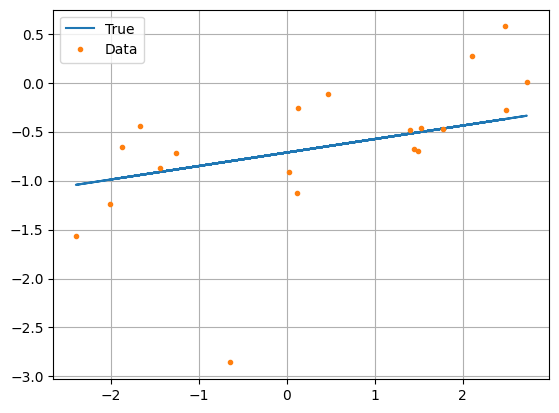

In [28]:
y_true = A_true*x + b_true
y = A_true*x + b_true + torch.randn(20)*0.5

plt.plot(x, y_true)
plt.plot(x, y, '.')
plt.grid('on')
plt.legend(('True', 'Data'))
plt.show()

We're now ready to train. We will use ```.data``` to directly modify the value of tensors without it being kept track of in the computation graph.

In [29]:
A = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

lr = 0.005
N = 500

for t in range(N):
    y_estimate = A*x + b
    
    loss = (y_estimate - y).square().mean()
    
    # Zero the accumulated gradients
    A.grad = None
    b.grad = None
    
    # Compute the gradient
    loss.backward()
    
    # Gradient descent step
    A.data = (A - lr*A.grad).data
    b.data = (b - lr*b.grad).data

In [30]:
print(A_true, A)
print(b_true, b)

tensor([0.1376]) tensor([0.2506], requires_grad=True)
tensor([-0.7129]) tensor([-0.7368], requires_grad=True)


Instead of manually writing the gradient descent update, we can use ```torch.optim.SGD``` to do this for us. It takes the list of parameters to optimize. The optimizer also has ```.zero_grad()``` to zero out the accumulated gradients. We will add a log of the different values at each step of training for visualization later.

In [31]:
A = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

lr = 0.005
N = 500

optimizer = torch.optim.SGD([A, b], lr=lr)

## Log
logs_A = []
logs_b = []
##

for t in range(N):
    y_estimate = A*x + b
    
    loss = (y_estimate - y).square().mean()
    
    # Zero the accumulated gradients
    optimizer.zero_grad()
    
    # Compute the gradient
    loss.backward()
    
    # Gradient descent step
    optimizer.step()
    
    ## Log
    if t%1 == 0:
        logs_A.append(A.detach().numpy()[0])
        logs_b.append(b.detach().numpy()[0])
    ##

In [32]:
print(A_true, A)
print(b_true, b)

tensor([0.1376]) tensor([0.2515], requires_grad=True)
tensor([-0.7129]) tensor([-0.7417], requires_grad=True)


Let's get the analytic solution I mentioned above, and plot what we learned.

In [33]:
x_1 = np.array([x.numpy(), np.ones(20)]).T
A_b_scipy = scipy.linalg.lstsq(x_1, y.numpy())[0]
A_scipy = A_b_scipy[0]
b_scipy = A_b_scipy[1]

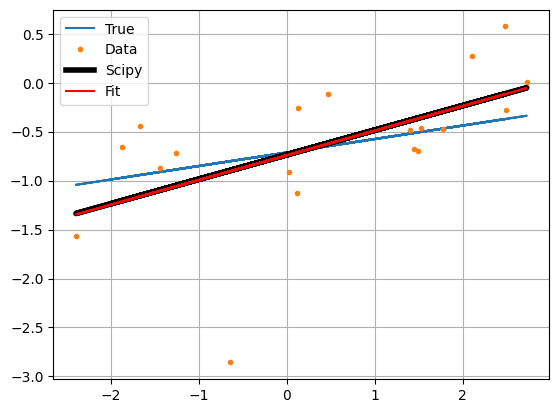

In [34]:
y_estimate = A*x + b
y_scipy = A_scipy*x + b_scipy

plt.plot(x, y_true)
plt.plot(x, y, '.')
plt.plot(x, y_scipy,'k',linewidth=4)
plt.plot(x, y_estimate.detach(), 'r-')
plt.grid('on')
plt.legend(('True', 'Data', 'Scipy', 'Fit'))

We get very close to the exact least squares solution (labeled "Scipy"). Before ending this section, let's visualize what each of the iterations look like during training.

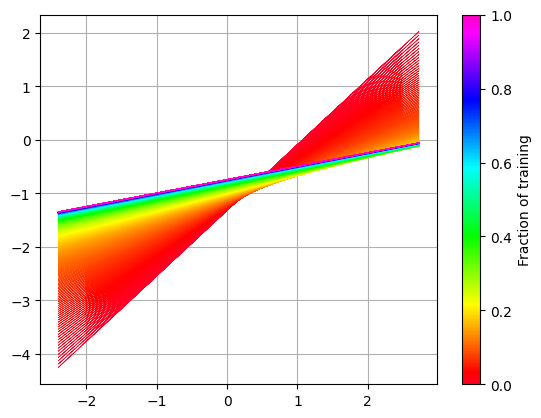

In [35]:
fig, ax = plt.subplots()
for t in range(len(logs_A)):
    ax.plot(x, logs_A[t]*x.numpy() + logs_b[t],c=plt.cm.gist_rainbow(t/len(logs_A)), linewidth=0.5)
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=plt.cm.gist_rainbow), ax=ax)
cbar.set_label("Fraction of training")
plt.grid('on')
plt.show()

## 3) Training a Neural Network on MNIST

In this part, we will train a neural network on the character recognition dataset [MNIST](https://en.wikipedia.org/wiki/MNIST_database). MNIST consists of images that are 28 x 28 pixels of the digits 0 through 9. Our goal is to classify what digit is in the image.

We begin by using ```torchvision``` to get the dataset. This will download the dataset and save it to the folder "./data". We will define a transformation that first transforms the input into a tensor, and then flattens it to a single vector of length $28^2$.

In [36]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(torch.flatten)])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 12398853.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 23761415.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 9943726.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 3124061.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let's look at a random element of the training dataset.

The label is 3.


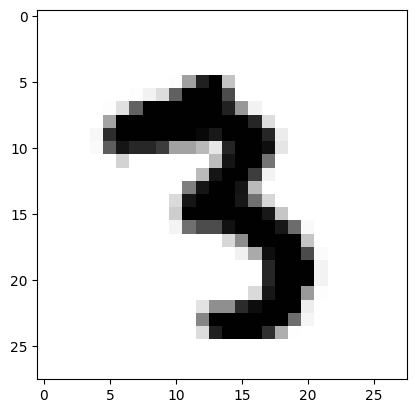

In [37]:
ind = torch.randint(len(mnist_train), (1,))[0]
x, y = mnist_train[ind]
print("The label is " + str(y) + ".")
plt.imshow(x.reshape(28,28).numpy(), cmap='binary')
plt.show()

We are ready to define our neural network. Our neural network will be a multilayer perceptron. A multilayer perceptron has layers consisting of an affine transformation ($y = Ax + b$) followed by a nonlinear activation function.

Let's use ```torch.nn``` to have nicely prepackaged functions. The first one will be our affine transformation. We will create ```nn.Linear(n, m)``` where $n$ is the input size and $m$ is the output size.

In [38]:
linear_layer = nn.Linear(2,3)
print(linear_layer.weight)
print(linear_layer.bias)

Parameter containing:
tensor([[ 0.1586,  0.5196],
        [ 0.0450,  0.4533],
        [-0.3766, -0.3964]], requires_grad=True)
Parameter containing:
tensor([-0.6922,  0.5905,  0.0286], requires_grad=True)


The weights are $A$ and the bias is $b$ in $y = Ax + b$. We can call this with values of different sizes. Note that our input of size $2$ becomes an output of size $3$ in this example. Only the last dimension has the affine transformation applied. Everything else is iterated over.

In [39]:
x = torch.randn(2)
linear_layer(x)

tensor([-0.5656,  0.5122, -0.5841], grad_fn=<ViewBackward0>)

Note that this

In [40]:
x = torch.randn(5,2)
linear_layer(x)

tensor([[-0.3345,  0.9254, -0.1817],
        [-0.4801,  0.5933, -0.6317],
        [-0.1935,  1.0808, -0.2006],
        [-0.0636,  1.2263, -0.2117],
        [-0.2599,  1.0936,  0.0435]], grad_fn=<AddmmBackward0>)

is semantically the same as

In [41]:
for t in range(5):
    print(linear_layer(x[t]))

tensor([-0.3345,  0.9254, -0.1817], grad_fn=<ViewBackward0>)
tensor([-0.4801,  0.5933, -0.6317], grad_fn=<ViewBackward0>)
tensor([-0.1935,  1.0808, -0.2006], grad_fn=<ViewBackward0>)
tensor([-0.0636,  1.2263, -0.2117], grad_fn=<ViewBackward0>)
tensor([-0.2599,  1.0936,  0.0435], grad_fn=<ViewBackward0>)


but the first one is preferred, as PyTorch will automically parallelize it.

Of course, we get an error if we call ```linear_layer``` with the wrong size.

In [42]:
try:
    x = torch.randn(3)
    linear_layer(x)
except Exception as e:
    print("Error!")
    print(e)

Error!
mat1 and mat2 shapes cannot be multiplied (1x3 and 2x3)


We can check that this is in fact just $Ax + b$ (with a transpose).

In [43]:
x = torch.randn(2)
A = linear_layer.weight.data.detach().clone()
b = linear_layer.bias.data.detach().clone()

print(x @ A.T + b)
print(linear_layer(x))

tensor([-1.0951,  0.2965,  0.4932])
tensor([-1.0951,  0.2965,  0.4932], grad_fn=<ViewBackward0>)


For our activation function, we will use [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), $f(x) = \max(0, x)$, by calling ```torch.relu(x)```. Let's plot what it looks like.

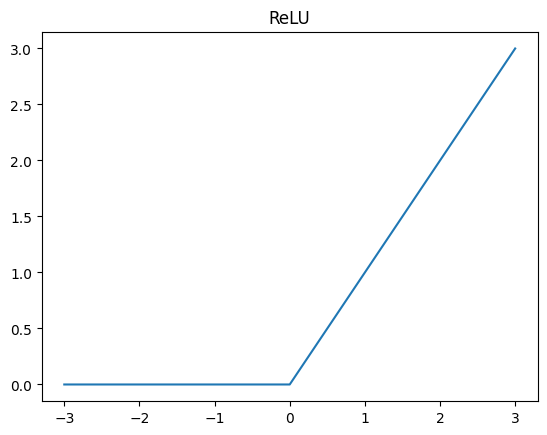

In [44]:
x = torch.linspace(-3, 3, 41)
plt.title('ReLU')
plt.plot(x, torch.relu(x))
plt.show()

Now we are ready to define our neural network. We will define it as a class that extends ```nn.Module```. When the object is called, ```forward``` will automatically be called. Note that we need to call the initialization of the superclass at the beginning of our initialization.

In [45]:
class FFN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=200):
        super().__init__()
        self.lin0 = nn.Linear(input_dim, hidden_dim)
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.lin0(x))
        x = torch.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [46]:
ffn = FFN(28*28, 10)
ffn(torch.randn(28*28))

tensor([-0.0438,  0.0846, -0.0045,  0.0959, -0.1326, -0.0733, -0.0720,  0.0080,
        -0.1208,  0.0065], grad_fn=<ViewBackward0>)

Now we can use a ```DataLoader``` to automatically sample a minibatch of size $16$ for training.

In [47]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1)

Here's our training loop. We will use the [cross entropy loss](https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_loss_function_and_logistic_regression) which will just correspond to the negative log probability our model assigns to the correct class. We use a softmax to get the probabilities from the logits our model outputs. The value computed in the commented out code will match that computed by ```nn.CrossEntropyLoss```.

```torch.optim``` has many other variants of stochastic gradient descent we will use later. In particular, [Adam](https://arxiv.org/pdf/1412.6980.pdf), which takes an exponential average of the gradients and divides it by the exponential average of the uncentered variance to get the update direction. We will use that here.

In [48]:
num_epochs = 1

ffn = FFN(28*28, 10)
optimizer = torch.optim.Adam(ffn.parameters(), lr=3e-4)

CEL = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    for x, y_true in tqdm(train_loader):
        y_logits = ffn(x)
        
        # y_probs_all = torch.softmax(y_logits, dim=-1)
        # y_prob = y_probs_all[torch.arange(len(y_probs_all)), y_true]
        # loss = -torch.log(y_prob).mean()
        
        loss = CEL(y_logits, y_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████| 3750/3750 [00:11<00:00, 328.89it/s]


Let's compute the accuracy on the test set.

In [49]:
num_correct = 0

for x, y_true in tqdm(test_loader):
    num_correct += (y_true == ffn(x).max(dim=-1)[1])
    
print('Test accuracy:', float(num_correct / len(test_loader)))

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 3040.16it/s]

Test accuracy: 0.9459999799728394


After training for just a few seconds, we have nearly 95% accuracy on the test set!

Let's look at some random element of the test set what the network classifies it as.

The label is 7.
The network predicted 7.


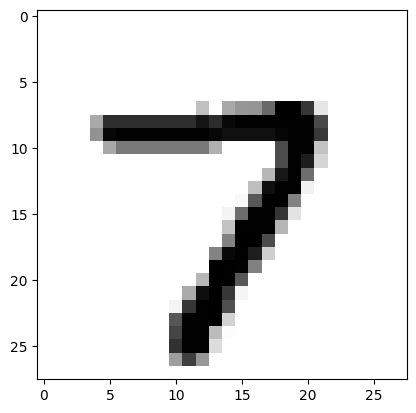

In [50]:
ind = torch.randint(len(mnist_test), (1,))[0]
x, y = mnist_test[ind]
print("The label is " + str(y) + ".")
print("The network predicted " + str(int(ffn(x).max(dim=-1)[1])) + ".")
plt.imshow(x.reshape(28,28).numpy(), cmap='binary')
plt.show()

Let's randomly sample elements from the test set until we find one that the network misclassifies and look at it.

The label is 2.
The network predicted 4.


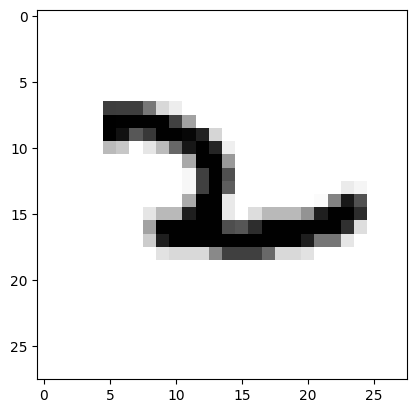

In [51]:
while True:
    ind = torch.randint(len(mnist_test), (1,))[0]
    x, y = mnist_test[ind]
    if ffn(x).max(dim=-1)[1] != y:
        break
print("The label is " + str(y) + ".")
print("The network predicted " + str(int(ffn(x).max(dim=-1)[1])) + ".")
plt.imshow(x.reshape(28,28).numpy(), cmap='binary')
plt.show()

The network is misclassifying tricky examples, which is good to see.

## 4) Deep Deterministic Policy Gradient (DDPG)

Finally, let's implement [DDPG](https://arxiv.org/pdf/1509.02971.pdf). DDPG will consist of the following training loop:
 1) Pick action a, and put observed transition (s, a, r', s') in replay buffer
 
 2) Sample from replay buffer and compute Q-learning targets
 
 3) (Critic) Minimize mean squared error to the targets
 
 4) (Actor) Do gradient ascent in Q-value

Let's begin by setting up the environment from [Gymnasium](https://gymnasium.farama.org/). The environment [Pendulum-v1](https://gymnasium.farama.org/environments/classic_control/pendulum/) consists of a rod attached to a pivot point. At this pivot point is an underpowered motor. The goal is to actuate the motor to get the pendulum to go upright.

The environment has two critical function ```reset()``` which resets the agent to the start of an episode and ```step(action)``` which advances the environment under a particular action.

```reset()``` returns the state and a dictionary of debugging information.

In [52]:
env = gym.make('Pendulum-v1')

S, info = env.reset()

print(S) # [ cos(theta), sin(theta), angular velocity ]
print(info)

[ 0.03540277  0.99937314 -0.24857172]
{}


The action space on this problem consists of a single action that can be in the range -2 to 2.

In [53]:
env.action_space # torque, [-2.0, 2.0]

Box(-2.0, 2.0, (1,), float32)

```step(action)``` returns 
 - the next state, 
 - the reward, 
 - whether or not the episode has "terminated" by transitioning to a zero value sink, 
 - whether or not the episode has timed out
 - a dictionary of debugging information

In [54]:
action = np.array([0.])
sPrime, R, terminated, truncated, info = env.step(action)
print("Next state", sPrime)
print("Reward", R)
print("Terminated", terminated)
print("Truncated", truncated)
print("Info", info)

Next state [0.01036208 0.9999463  0.5009581 ]
Reward -2.3635894380183595
Terminated False
Truncated False
Info {}


Let's set some useful variables about the state and action spaces.

In [55]:
action_dim = env.action_space.high.shape[0]
state_dim = env.observation_space.high.shape[0]

action_low = torch.tensor(env.action_space.low)
action_high = torch.tensor(env.action_space.high)

Let's perform a rollout by repeatedly selecting a random action and executing it until either ```terminated``` or ```truncated``` is true. By setting ```render_mode='human'``` we will be able to call ```env.render()``` to get a small window that shows us what is happening in the environment. When the rollout is done, we'll call ```env.close()``` to get rid of this window and then we will reinstantiate the environment.

The arrow shows the motor torque being applied.

In [56]:
env = gym.make('Pendulum-v1', render_mode='human')

for episode in range(3):
    print("Episode", episode)
    S, info = env.reset()
    done = False
    while not done:
        randAction = env.action_space.sample()
        sPrime, R, terminated, truncated, info = env.step(randAction)
        done = terminated or truncated
        env.render()
        S = sPrime
env.close()

Episode 0
Episode 1
Episode 2


Here's a screenshot of what this looks like
![Pendulum](pendulum_random.png)

In [57]:
env = gym.make('Pendulum-v1')

Next, let's define the replay buffer, which keeps stores a transition consisting of a state, action, observed reward, observed next state, and termination signal. This will have two functions ```add``` to add a transition and ```sample``` to get ```num_samples``` transitions from the replay buffer.

In [58]:
class ReplayBuffer():
    def __init__(self, buffer_size, state_dim, action_dim):
        self.states = np.zeros((buffer_size, state_dim))
        self.actions = np.zeros((buffer_size, action_dim))
        self.rewards = np.zeros((buffer_size, 1))
        self.statesPrime = np.zeros((buffer_size, state_dim))
        self.terms = np.zeros((buffer_size, 1))
    
        self.ind = 0
        self.buffer_size = buffer_size
        self.buffer_len = 0
    
    def __len__(self):
        return self.buffer_len
    
    def add(self, S, A, R, sPrime, term):
        self.states[self.ind] = S
        self.actions[self.ind] = A
        self.rewards[self.ind] = R
        self.statesPrime[self.ind] = sPrime
        self.terms[self.ind] = term
        
        self.ind += 1
        self.buffer_len = max(self.buffer_len, self.ind)
        if self.ind == self.buffer_size:
            self.ind = 0
        
    def sample(self, num_samples):
        sampled_indices = np.random.randint(0, self.buffer_len, num_samples)
        return dict(
            states=torch.FloatTensor(self.states[sampled_indices]),
            actions=torch.FloatTensor(self.actions[sampled_indices]),
            rewards=torch.FloatTensor(self.rewards[sampled_indices]),
            statesPrime=torch.FloatTensor(self.statesPrime[sampled_indices]),
            terms=torch.FloatTensor(self.terms[sampled_indices])
        )

We will define another neural network, but this time the number of layers is a parameter. We can do this by using ```nn.Sequential``` which takes a list of modules and applies them in sequence.

In [59]:
class FFN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=200, hidden_layers=1, activation_fn=nn.Tanh()):
        super().__init__()
        
        seq = [nn.Linear(input_dim, hidden_dim), activation_fn]
        
        for _ in range(hidden_layers-1):
            seq.append(nn.Linear(hidden_dim, hidden_dim))
            seq.append(activation_fn)
        
        seq.append(nn.Linear(hidden_dim, output_dim))
        
        self.model = nn.Sequential(*seq)
    
    def forward(self, x):
        return self.model(x)

Now we will define the actor, which takes a state and return an action in the allowed range, and the critic, which takes a state and action, and returns a value.

In [60]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_low, action_high,
                 hidden_dim=200, hidden_layers=1, activation_fn=nn.Tanh()):
        super().__init__()
        
        self.model = FFN(state_dim, action_dim, 
                         hidden_dim=hidden_dim, hidden_layers=hidden_layers, activation_fn=activation_fn)
        
        self.action_low = action_low
        self.action_high = action_high
        
        self.action_mean = (self.action_low + self.action_high)/2
        self.action_scale = (self.action_high - self.action_low)/2
    
    def forward(self, state):
        x = self.model(state)
        return torch.tanh(x)*self.action_scale + self.action_mean
    
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim,
                 hidden_dim=200, hidden_layers=1, activation_fn=nn.Tanh()):
        super().__init__()
        
        self.model = FFN(state_dim+action_dim, 1, 
                         hidden_dim=hidden_dim, hidden_layers=hidden_layers, activation_fn=activation_fn)
        
    def forward(self, state, action):
        return self.model(torch.hstack((state, action)))

We define the following helper function to update the target networks. This implements the update 
$$\theta_{\text{out}} \leftarrow (1-\tau)\theta_{\text{out}} + \tau\theta_{\text{in}}$$

In [61]:
def update_weights(net_in, net_out, tau=5e-3):
    with torch.no_grad():
            for net_in_param, net_out_param in zip(net_in.parameters(), net_out.parameters()):
                net_out_param.data.copy_((1-tau) * net_out_param.data + tau * net_in_param.data)

Now we will define the logger, which uses [TensorBoard](https://www.tensorflow.org/tensorboard) to visualize the sum of the rewards and length of each episode. To start TensorBoard with the log directory we will use, run ```tensorboard --logdir=/tmp/tf_log``` in a console.

In [62]:
# Logger
class Logger():
    def __init__(self, tensorboard_log, verbose=0):        
        self.writer = SummaryWriter(tensorboard_log, flush_secs=1)

    def log(self, train_step, episode_reward, episode_length):
        self.writer.add_scalar('rollout/episode_reward', episode_reward, train_step)
        self.writer.add_scalar('rollout/episode_length', episode_length, train_step)

And finally, we implement DDPG!

In [63]:
## DDPG parameters
gamma = 0.99
num_train_steps = int(5e4)
buffer_size = int(2e4)
tau = 1e-2
batch_size = 64
warm_up_steps = 5000
noise_scale = 0.2

## Network parameters
actor_hidden_dim = 400
actor_hidden_layers = 2
actor_activation_fn = nn.ReLU()

critic_hidden_dim = 400
critic_hidden_layers = 2
critic_activation_fn = nn.ReLU()

## Optimizer parameters
opt = torch.optim.Adam
actor_lr = 3e-4
critic_lr = 3e-4

## Logger parameters
logfile = "/tmp/tf_log/pendulum"

# Create actor and critic
actor = Actor(state_dim, action_dim, action_low, action_high, 
              hidden_dim=actor_hidden_dim, hidden_layers=actor_hidden_layers, activation_fn=actor_activation_fn)

critic = Critic(state_dim, action_dim,
                hidden_dim=critic_hidden_dim, hidden_layers=critic_hidden_layers, activation_fn=critic_activation_fn)

# Create target networks
target_actor = deepcopy(actor)
target_critic = deepcopy(critic)

# Create optimizers
actor_optim = opt(actor.parameters(), lr=actor_lr)
critic_optim = opt(critic.parameters(), lr=critic_lr)

# Create replay buffer
replay_buffer = ReplayBuffer(buffer_size, state_dim, action_dim)

# Create logger
logger = Logger(logfile)

train_step = 0

# Setup progress bar with tqdm
with tqdm(total=num_train_steps) as pbar:
    
    while train_step < num_train_steps:
        # Reset episode
        done = False
        S, info = env.reset()
        episode_R = 0 # Keeps track of sum of rewards along episode
        episode_len = 0 # Keeps track of episode length

        while not done and train_step < num_train_steps:
            # Pick action
            raw_action = ( actor(torch.tensor(S)) + torch.randn(action_dim)*noise_scale ).detach()
            action = raw_action.clip(action_low, action_high).numpy()

            # Sample transition
            sPrime, R, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            train_step += 1
            pbar.update(1)

            ## Log
            episode_R += R
            episode_len += 1
            if done:
                logger.log(train_step, episode_R, episode_len)
                episode_R = 0
                episode_len = 0
            ##

            # Add to replay buffer
            replay_buffer.add(S, action, R, sPrime, terminated)

            # Shift S for next timestep
            S = sPrime

            # Update networks
            if train_step <= warm_up_steps: # If we are still warming up, don't update the networks
                continue

            # Sample from replay buffer
            samples = replay_buffer.sample(batch_size)

            # Update critic
            ## Compute Q-learning target
            targ_action = target_actor(samples["statesPrime"])
            targ_nextQs = target_critic(samples["statesPrime"], targ_action)
            targ_Qs = (samples["rewards"] + gamma*targ_nextQs*(1-samples["terms"])).detach()

            ## Loss is mean squared error to target
            Qs = critic(samples["states"], samples["actions"])
            critic_loss = (targ_Qs - Qs).square().mean()

            critic_optim.zero_grad()
            critic_loss.backward()
            critic_optim.step()

            # Update actor
            ## Loss is the negative of the Q-value the critic predicts for the actor's action
            actions = actor(samples["states"])
            actor_loss = -critic(samples["states"], actions).mean()

            actor_optim.zero_grad()
            actor_loss.backward()
            actor_optim.step()

            ## Update target networks
            update_weights(critic, target_critic, tau=tau)
            update_weights(actor, target_actor, tau=tau)

100%|████████████████████████████████████| 50000/50000 [04:27<00:00, 186.91it/s]


Now it is done training. The output in TensorBoard looks like this:
![TensorBoard output](tensorboard.png)

We can see that the agent had learned a good policy after about 10k training steps (about 1 minute of real time).

Let's watch the trained policy. We will see that it has learned to balance the pendulum.

In [64]:
env = gym.make('Pendulum-v1', render_mode='human')

for episode in range(5):
    print("Episode", episode)
    S, info = env.reset()
    done = False
    while not done:
        action = actor(torch.tensor(S)).detach().numpy()
        sPrime, R, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        env.render()
        S = sPrime
env.close()

Episode 0
Episode 1
Episode 2
Episode 3
Episode 4


Here's a screenshot of what this looks like
![Pendulum](pendulum_trained.png)

We can save the actor's weights

In [65]:
torch.save(actor.state_dict(), "actor.pt")

and load them in.

In [66]:
new_actor = Actor(state_dim, action_dim, action_low, action_high, 
                  hidden_dim=actor_hidden_dim, hidden_layers=actor_hidden_layers, activation_fn=actor_activation_fn)
new_actor.load_state_dict(torch.load("actor.pt"))

<All keys matched successfully>

And now we are done! For more reading on PyTorch, take a look at their [tutorials](https://pytorch.org/tutorials/). For more reading on deep reinforcement learning, [this blog](https://pytorch.org/tutorials/) is very well written.